In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, brier_score_loss, roc_curve, auc
import matplotlib.pyplot as plt

In [6]:
# Load dataset
spam_notspam = pd.read_csv("/Users/divyanshjanu/Desktop/app/spam.csv", encoding='latin-1')

In [7]:
df = spam_notspam
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
df.rename(columns={'v1': 'SPAM/HAM', 'v2': 'Text'} , inplace=True)

In [9]:
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

In [10]:
df

,SPAM/HAM,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [11]:
# Define the target column (y) and feature columns (X)
X = spam_notspam['Text']  # Feature column (input variables)
y = spam_notspam['SPAM/HAM'].map({'ham': 0, 'spam': 1})    # Target column (output variable)

In [12]:
X

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: Text, Length: 5572, dtype: object

In [13]:
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: SPAM/HAM, Length: 5572, dtype: int64

In [14]:
vectorizer = TfidfVectorizer(max_features=5000)  # Use up to 5000 features
X_tfidf = vectorizer.fit_transform(X)

In [15]:
scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse matrices
X_scaled = scaler.fit_transform(X_tfidf.toarray())

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (4457, 5000)
Testing data shape: (1115, 5000)


In [17]:
# Logistic Regression
model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)

LogisticRegression(max_iter=300)

In [18]:
# XGBoost
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [19]:
# Make predictions for both models
y_pred_log_reg = model.predict(X_test)
y_pred_xgb = model.predict(X_test)

In [20]:
# Get probabilities for both models (for AUC, Brier Score, etc.)
y_prob_log_reg = model.predict_proba(X_test)[:, 1]
y_prob_xgb = model.predict_proba(X_test)[:, 1]

In [21]:
# Combine the predictions by averaging
combined_preds = (y_pred_log_reg + y_pred_xgb) / 2
combined_probs = (y_prob_log_reg + y_prob_xgb) / 2

In [22]:
# Evaluate Combined Performance Metrics
roc_auc_combined = roc_auc_score(y_test, combined_probs)
f1_combined = f1_score(y_test, combined_preds)
precision_combined = precision_score(y_test, combined_preds)
recall_combined = recall_score(y_test, combined_preds)
brier_score_combined = brier_score_loss(y_test, combined_probs)

In [23]:
# Combine the overall performance metrics into a DataFrame for easy comparison
Model_df = pd.DataFrame({
    'Metric': ['ROC AUC', 'F1 Score', 'Precision', 'Recall', 'Brier Score'],
    'Model performance': [roc_auc_combined, f1_combined, precision_combined, recall_combined, brier_score_combined]
})

Model_df

,Metric,Model performance
0,ROC AUC,0.983972
1,F1 Score,0.909747
2,Precision,0.984375
3,Recall,0.845638
4,Brier Score,0.018618


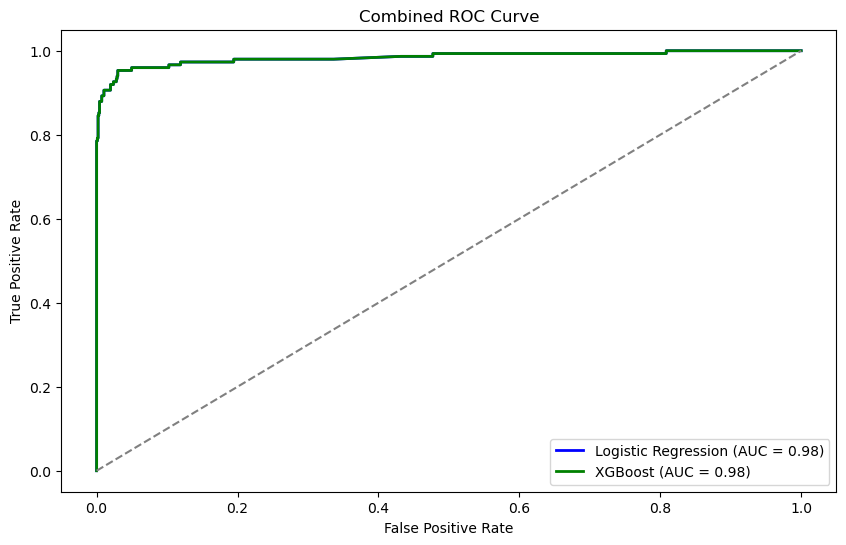

In [24]:
# Visualize the ROC Curve for Combined Model
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_prob_log_reg)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_log_reg, tpr_log_reg, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_combined:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {roc_auc_combined:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curve')
plt.legend(loc='lower right')
plt.show()